In [1]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
from scipy.stats import norm, skew 
import matplotlib.pyplot as plt
from scipy import stats
path = 'C:/Users/Дима/jupyter/ЦИАН/first_blood/2preparing/'

df = pd.read_csv(path+'cian_data.csv', sep = '\t')

In [2]:
target = ['цена']

text_data = ['адрес','метро', 'тайтл', 'stations_auto',
            'stations_walk', 'описание']

#Обработать
strange_val = ['Площадь комнат','lat', 'long','href'
               'срок сдачи']

time_val = ['Построен','Год постройки', 'Срок сдачи', 'год сдачи',
           'квартал']

cont_var = ['Общая', 'Жилая', 'Кухня','metro_walk_min','metro_auto_min',
           'возраст', 'Этажность','Этаж']

var_cat = ['Тип жилья', 'Ремонт',
'Вид из окон', 'Тип дома', 'Тип перекрытий',
'Отопление', 'Парковка', 'Мусоропровод',
'Высота потолков', 'Планировка', 'Газоснабжение',
'Отделка', 'балконы',   'лоджии',
'санузлы_раздельные', 'санузлы_совместные', 'лифты_пас',
'лифты_гр', 'Тип_квартиры', 'первый_этаж', 'последний_этаж', 
'Подъезды'] 

In [3]:
df['балконы'].value_counts()

1         8477
2         1080
другое     205
Name: балконы, dtype: int64

Будем использовать только категориальные и непрерывные переменные. го!

# Сначала как всегда поделим train-test

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df[cont_var + var_cat]
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42)

## 1. Определимся с целевой переменной


 mu = 35462778.75 and sigma = 83656824.56



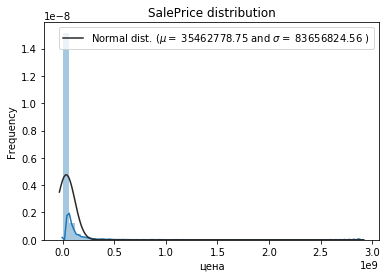

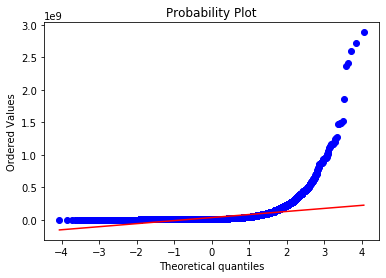

In [7]:
sns.distplot(y_train['цена'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train['цена'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train['цена'], plot=plt)
plt.show()


 mu = 16.70 and sigma = 0.96



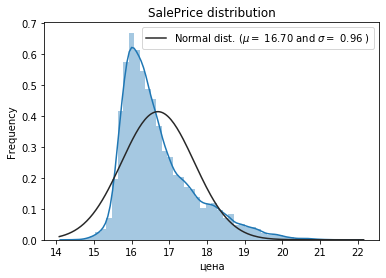

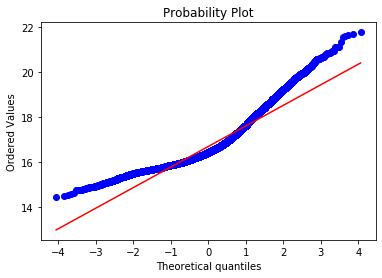

In [8]:
price_log = np.log1p(y_train['цена'])

sns.distplot(price_log  , fit=norm);


(mu, sigma) = norm.fit(price_log)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = stats.probplot(price_log , plot=plt)
plt.show()

Не очень, окей, попробуем избавится от больших значений

In [9]:
y_train = np.array(y_train)

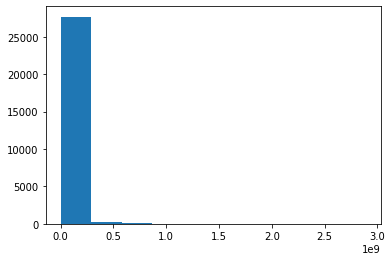

In [10]:
plt.hist(y_train);

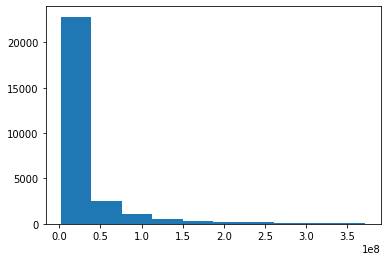

In [11]:
plt.hist(y_train[y_train<np.quantile(y_train, 0.99)]);

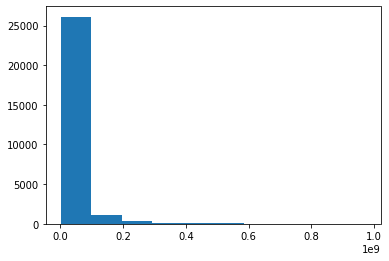

In [12]:
plt.hist(y_train[y_train<np.quantile(y_train, 0.999)]);

Возьмём границу в 400кк, и не забудем выкинуть их из фичей

In [13]:
X_train = X_train.iloc[(y_train<400000000)[:,0],:]
y_train = y_train[y_train<400000000]


 mu = 16.67 and sigma = 0.91



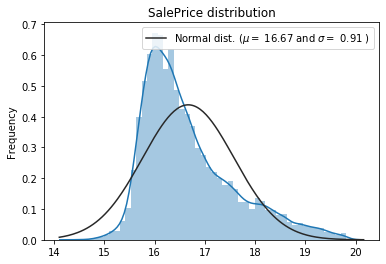

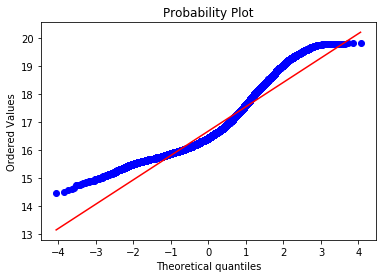

In [14]:
price_log = np.log1p(y_train)

sns.distplot(price_log  , fit=norm);


(mu, sigma) = norm.fit(price_log)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = stats.probplot(price_log , plot=plt)
plt.show()

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

square_ix = X_train[cont_var].columns.get_loc("Общая")
living_ix = X_train[cont_var].columns.get_loc("Жилая")
kitchen_ix = X_train[cont_var].columns.get_loc("Кухня")
floor_ix = X_train[cont_var].columns.get_loc("Этаж")
nfloor_ix = X_train[cont_var].columns.get_loc("Этажность")


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_freeplace = True):
        self.add_freeplace = add_freeplace
    def fit(self, X, y = None):
        return self  
    def transform(self, X):
        floor_ratio = X[:, floor_ix]/X[:, nfloor_ix]
        if self.add_freeplace:
            freeplace = X[:, square_ix] - X[:, living_ix] - X[:, kitchen_ix]
            return np.c_[X, freeplace,floor_ratio]

In [17]:
X_train[cont_var].isna().sum()

Общая                 0
Жилая              4972
Кухня              5321
metro_walk_min     7397
metro_auto_min    14154
возраст            8661
Этажность             0
Этаж                  0
dtype: int64

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(cont_var)),
    ("imputer", SimpleImputer(missing_values = np.nan,strategy="median")),
    ('attribs_adder',CombinedAttributesAdder( ))
    ])

# ПАЙПЛАЙН для категориальных переменных

In [19]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [20]:
from sklearn.preprocessing import OneHotEncoder

In [21]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(var_cat)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

Объединяем

In [22]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [23]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_train.shape

(27854, 94)

In [24]:
y_train = np.log1p(y_train)

In [40]:
X_train1 = X_train[:1000, :]

In [41]:
y_train1 = y_train[:1000]

# Протестим модельки

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet


RF

In [ ]:
param_grid = [
    {'n_estimators': [50,100,150,200,300,500], 
     'max_depth': [2, 4, 6, 8, 10,12,14,16],
    'criterion' :['mse', 'mae']},  
  ]

In [45]:
forest_rgr = RandomForestRegressor()
param_grid = [
    {'n_estimators': [50,100], 
     'max_depth': [2],
    'criterion' :['mse', 'mae']},  
  ]


gsc_rf = GridSearchCV(forest_rgr, param_grid, cv=8,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True )

gsc_rf.fit(X_train, y_train)



model_forest = gsc_rf.best_estimator_
model_scores = cross_val_score(model_forest, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
model_scores.mean()

KeyboardInterrupt: 

In [39]:
gsc_rf.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

ElNet

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
pipe = Pipeline([('preprocessing2',StandardScaler()),
                 ('regresion', ElasticNet())])

param_grid =[
    {'regresion__l1_ratio': [0.1, 0.5, 0.9, 0.99, 1],
     'regresion__alpha': [10**(-5),10**(-3), 10**(-1),1]}
]

grid = GridSearchCV(pipe, param_grid, cv=8,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True )
grid.fit(X_train,y_train)

model_elnet = grid.best_estimator_


C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1411.8888496616973, tolerance: 2.0269947741197014
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1399.6029940244775, tolerance: 2.011222064490977
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1388.5970384690818, tolerance: 2.0038798978236243
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.237538766601574, tolerance: 2.024290710406506
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.37953398176569, tolerance: 2.0269947741197014
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.31915178999088, tolerance: 2.011222064490977
  positive)
C:\Users\DIMA\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [58]:
model_elnet = grid.best_estimator_

In [61]:
model_elnet

Pipeline(memory=None,
         steps=[('preprocessing2',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regresion',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [53]:
X_test1 = preprocess_pipeline.transform(X_test)
X_test1.shape

(7022, 94)

In [54]:
y_test1 = np.log1p(y_test)

In [60]:
y_test1

,цена
9320,17.576478
9480,16.097893
11189,17.546911
30250,16.087637
32044,15.732433
...,...
27573,16.929026
27967,17.529083
8288,16.516872
21380,16.732909


In [62]:
model_elnet.predict(X_test1)

array([17.34169499, 16.77644316, 17.0617707 , ..., 16.53421535,
       16.67211417, 15.89439081])

In [59]:
model_scores = cross_val_score(model_elnet, X_test1, y_test1, cv=10, scoring='neg_mean_absolute_error')
model_scores.mean()

-0.31869627089996544

In [ ]:
feature_importance = pd.Series(index = train_X.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

XGB

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgbr = XGBRegressor()
param_grid = [
    {'min_child_weight':[1,4,5],
          'gamma':[i/10.0 for i in range(3,6)],  
          'subsample':[i/10.0 for i in range(6,11)],
            'colsample_bytree':[i/10.0 for i in range(6,11)], 
          'max_depth': [2,3,4]},  
  ]


gsc_xgbr = GridSearchCV(xgbr, param_grid, cv=8,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True )

gsc_xgbr.fit(X_train, y_train)



model_xgbr = gsc_xgbr.best_estimator_
model_scores = cross_val_score(model_xgbr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
model_scores.mean()

